In [15]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import glob
from inverserl.dataprocessing import multiply_location_change_per_axis, calculate_state_difference, update_eu_distance_2d
from inverserl.dataprocessing import generate_dfs_for_all_actions, create_text_line
from visualization.dataframevis import plot_normalized_distribution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
%reload_ext autoreload

In [17]:
# Hyperparameters
walking_stride = 0.3 # [m/sec]
actions = [0, 1, 2, 3, 4, 5, 6, 7] # the list of actions.

# Set the folder path for aggressive and conservative data.
agg_folder = 'Record/Aggressive/Data/'

# Initialize lists to hold CSV file paths.
agg_csv_list = []

# Append CSV file paths to the lists.
for file in glob.glob(agg_folder + '*.csv'):
    agg_csv_list.append(file)

# Convert CSV files into DataFrames.
agg_dfs = list(map(lambda file: pd.read_csv(file), agg_csv_list))

# Load the DataFrame representing state differences for each action.
dB = pd.read_csv("dfStateDifferenceForAllActions.csv")

# Preprocess dB by removing the index and modifying 'Agent Location Change'.
dB = dB.reset_index(drop=True)
# dB['Agent Location Change']: normalized vector [m/sec] of walking stride.
# so we modify 'Agent Location Change' by multiflying 'walking_stride.
dB['Agent Location Change'] = dB.apply(multiply_location_change_per_axis, walking_stride = walking_stride, axis=1)

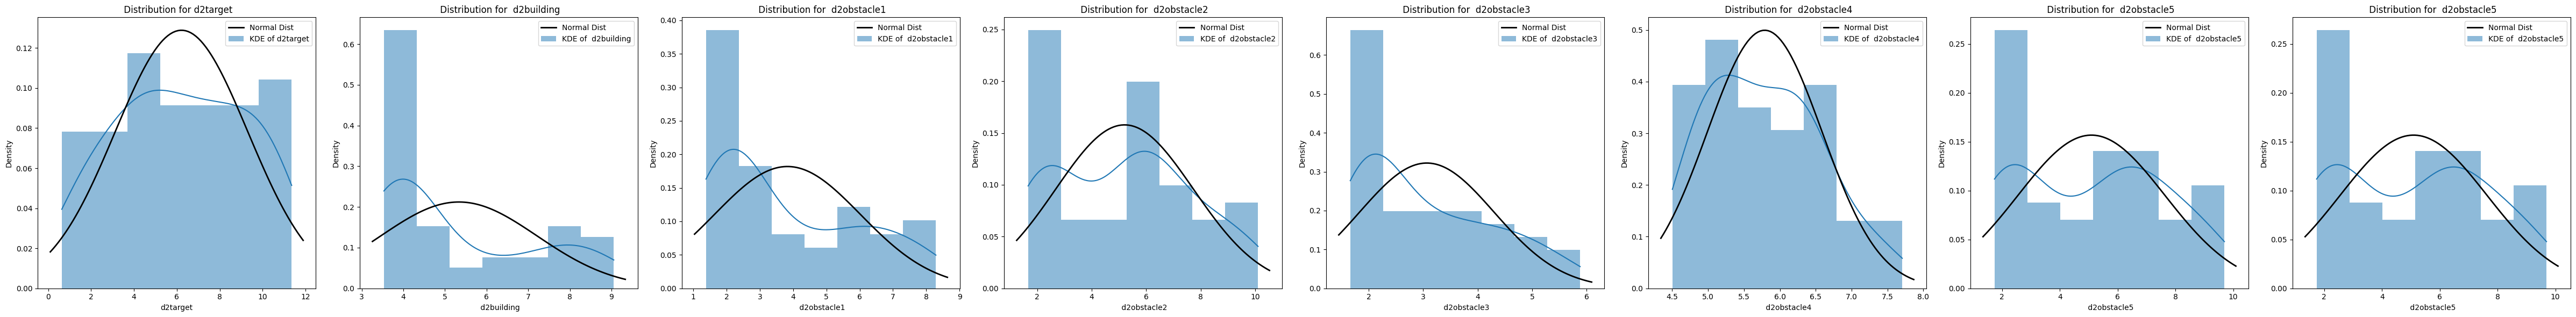

Saved file 'Record/Aggressive/Data/ExportedData_6.txt' successfully.
Saved file 'Record/Aggressive/Data//heatmapcsv/6heatmap.csv' successfully.


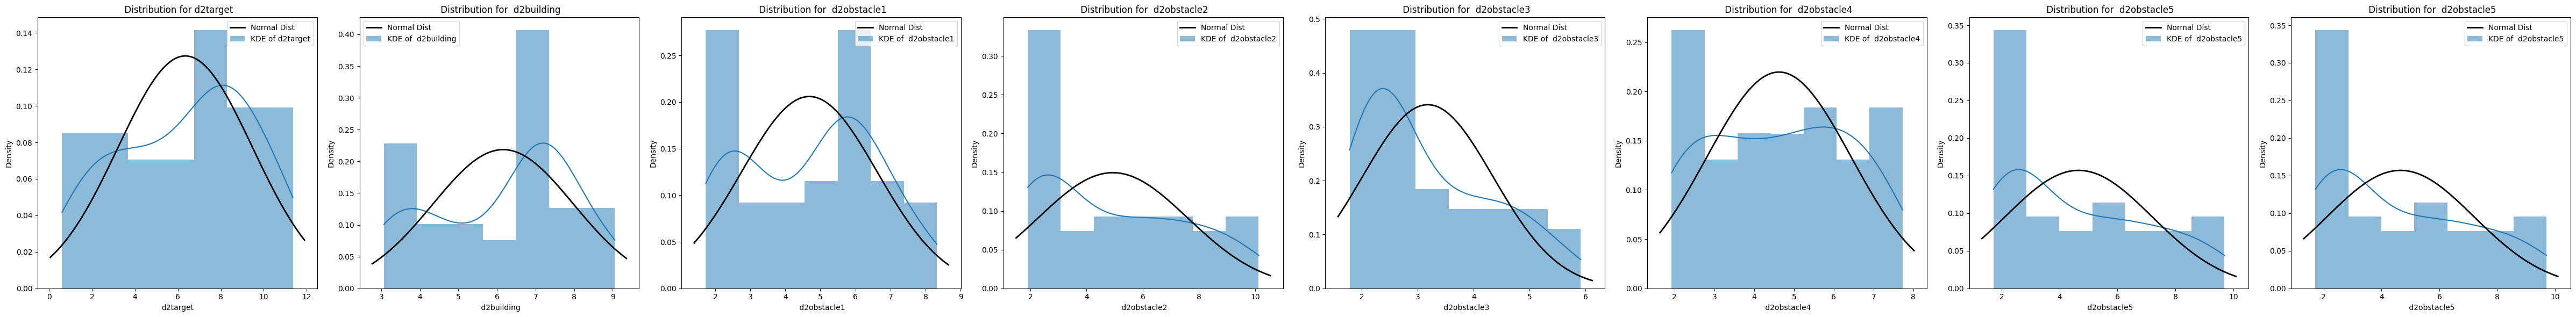

Saved file 'Record/Aggressive/Data/ExportedData_5.txt' successfully.
Saved file 'Record/Aggressive/Data//heatmapcsv/5heatmap.csv' successfully.


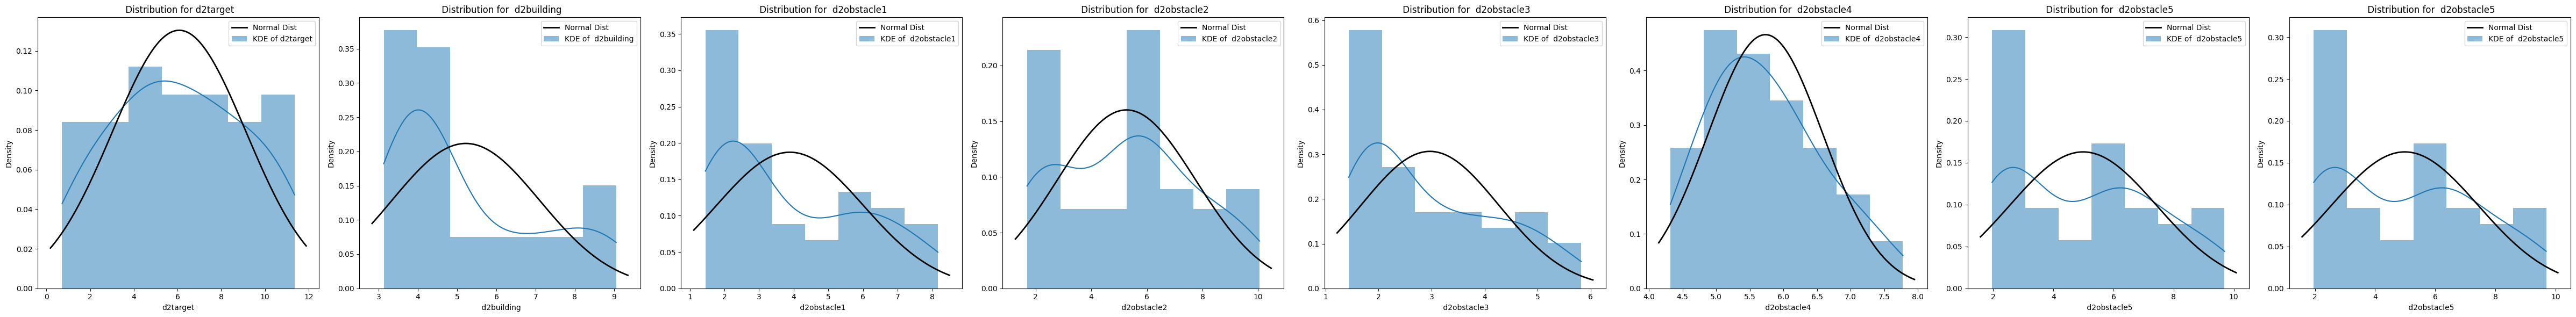

Saved file 'Record/Aggressive/Data/ExportedData_4.txt' successfully.
Saved file 'Record/Aggressive/Data//heatmapcsv/4heatmap.csv' successfully.


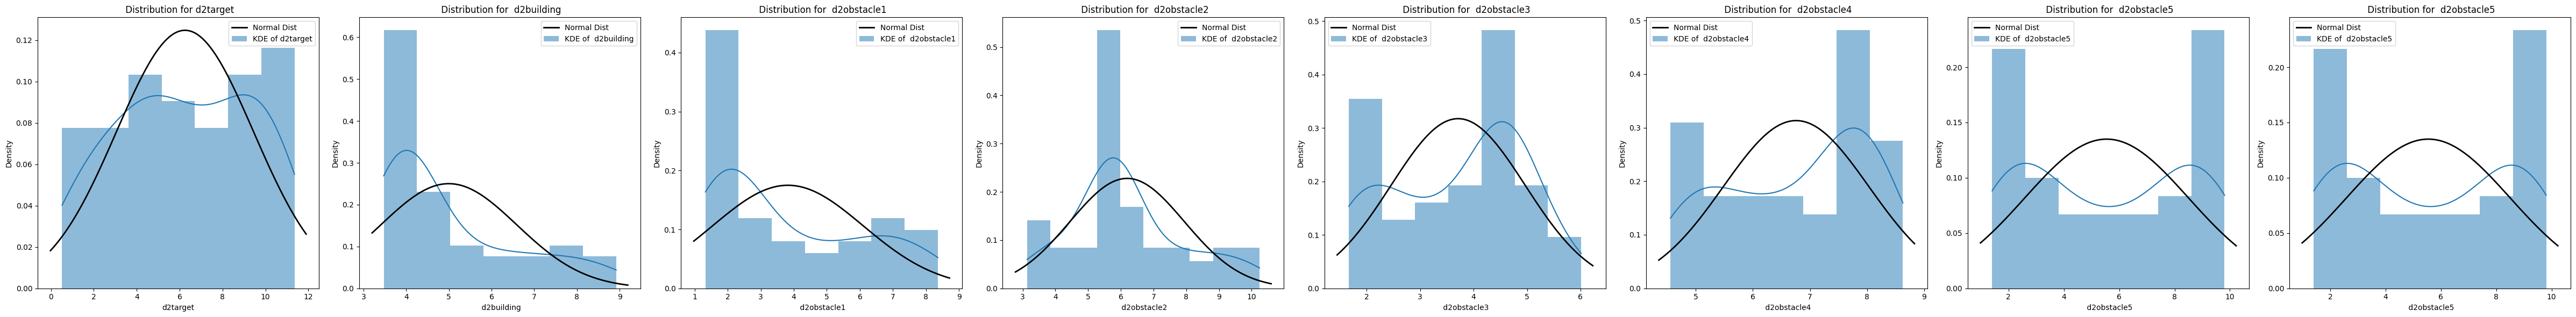

Saved file 'Record/Aggressive/Data/ExportedData_0.txt' successfully.
Saved file 'Record/Aggressive/Data//heatmapcsv/0heatmap.csv' successfully.


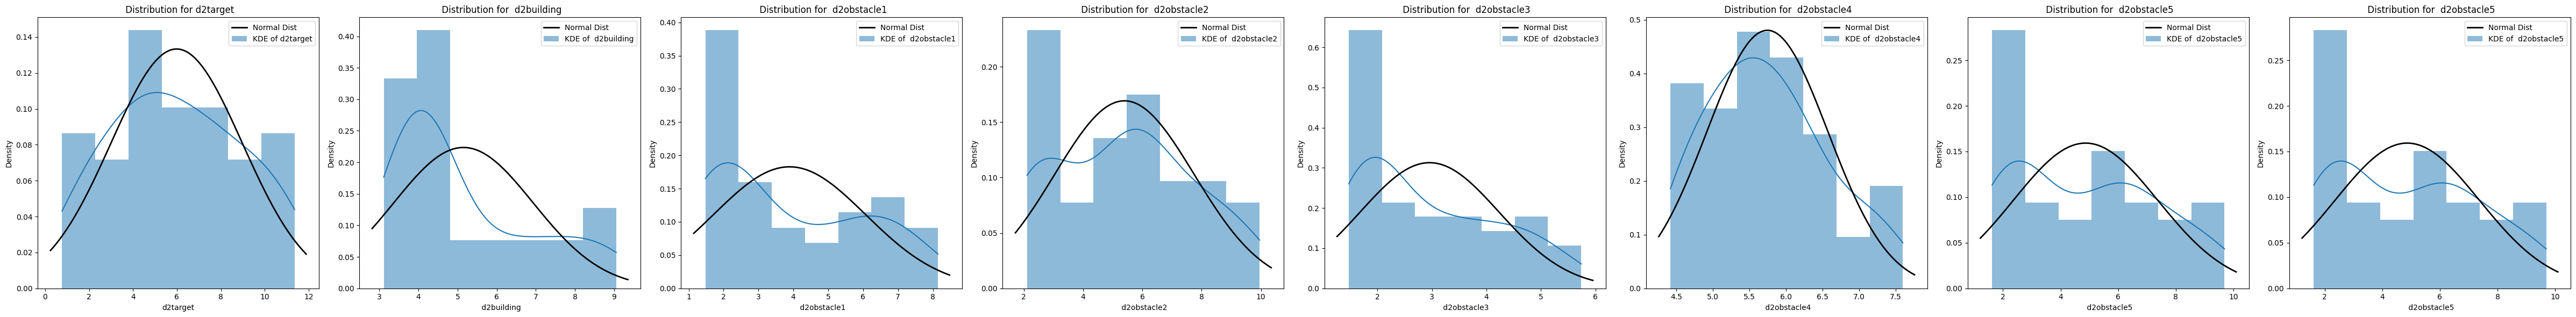

Saved file 'Record/Aggressive/Data/ExportedData_1.txt' successfully.
Saved file 'Record/Aggressive/Data//heatmapcsv/1heatmap.csv' successfully.


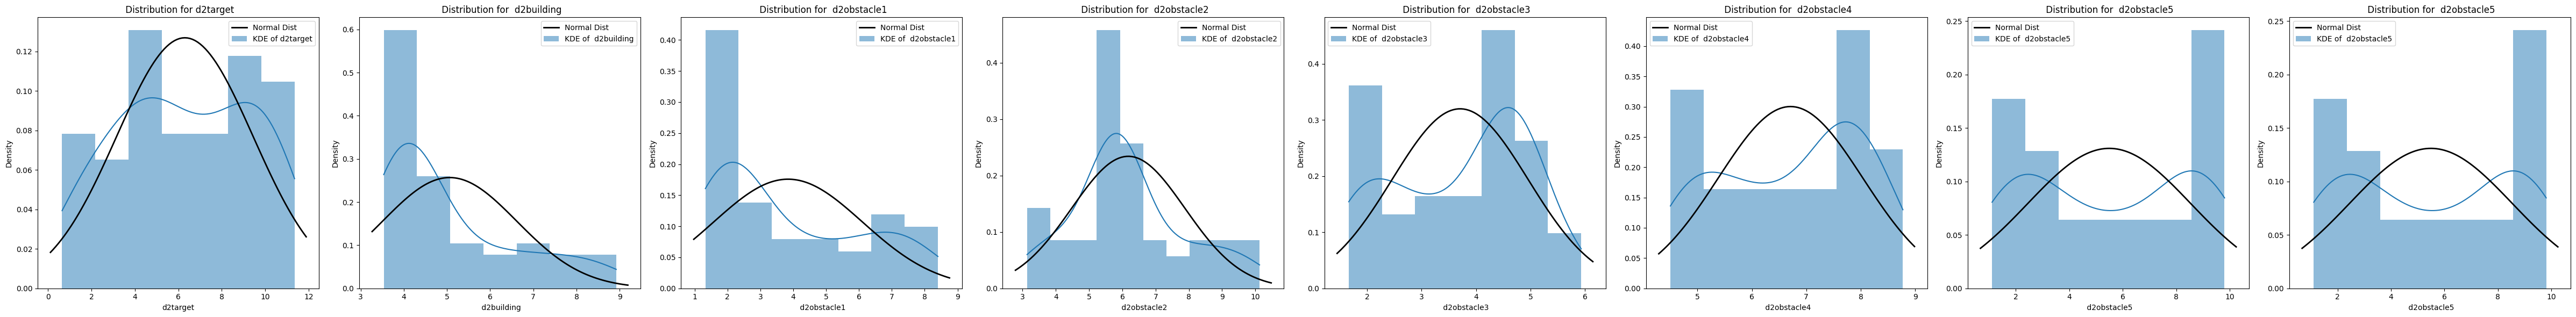

Saved file 'Record/Aggressive/Data/ExportedData_3.txt' successfully.
Saved file 'Record/Aggressive/Data//heatmapcsv/3heatmap.csv' successfully.


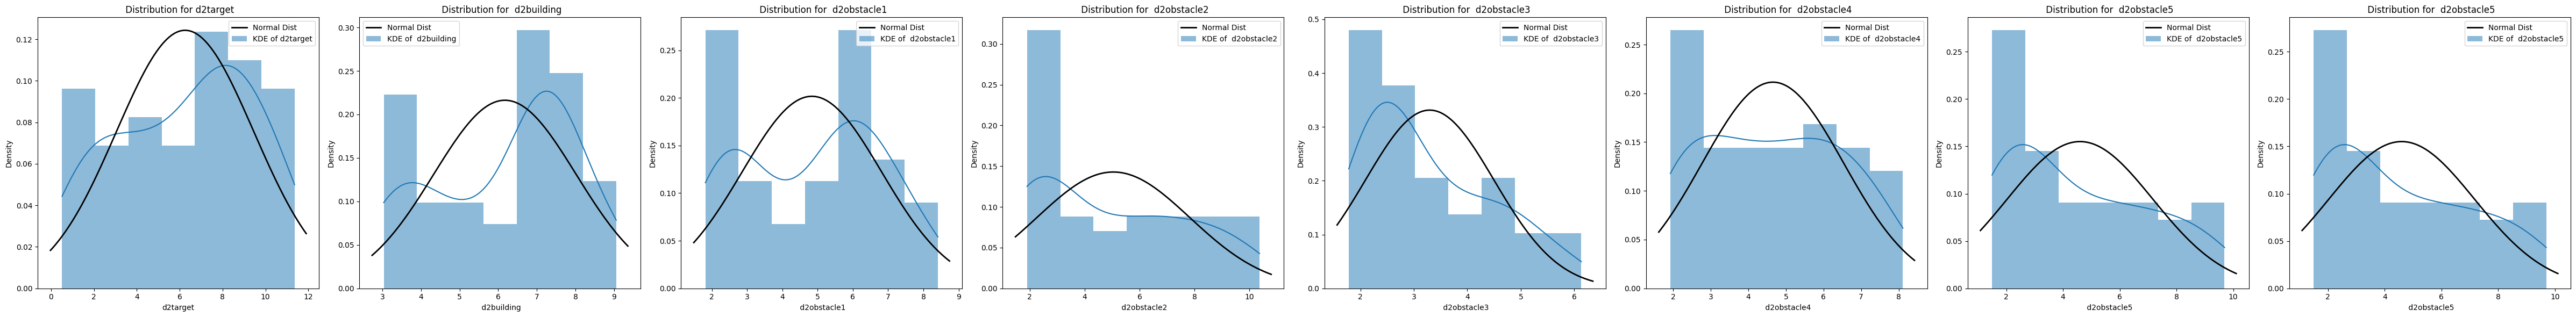

Saved file 'Record/Aggressive/Data/ExportedData_2.txt' successfully.
Saved file 'Record/Aggressive/Data//heatmapcsv/2heatmap.csv' successfully.


In [18]:
for i in range(len(agg_csv_list)): # for all records
    selectedFile = agg_csv_list[i]
    df = agg_dfs[i]

    # Preprocess the selected record by dropping specific columns.
    columns_to_drop = ['Timestamp', 'Nearest distance']
    df.drop(columns=columns_to_drop, axis=0, inplace=True)

    # Create copies of the DataFrame for different purposes.
    preprocessed_df = df.copy()
    dA = df.copy()

    # Check the normalization of Euclidean distances.
    distanceColumns = ['d2target',' d2building',' d2obstacle1',' d2obstacle2',' d2obstacle3',' d2obstacle4',' d2obstacle5',' d2obstacle5']
    plot_normalized_distribution(preprocessed_df, distanceColumns, False)

    # Merge dA with dB based on 'Action' and split 'Position' and 'Agent Location Change' into separate columns.
    merged_df = pd.merge(dA, dB, on='Action')
    merged_df[['pos_x', 'pos_y', 'pos_z']] = merged_df['Position'].str.split(expand=True).astype(float)
    merged_df[['diff_x', 'diff_y', 'diff_z']] = merged_df['Agent Location Change'].str.split(expand=True).astype(float) # state diff of the chosen action

    # Drop the original 'Position' and 'Agent Location Change' columns.
    merged_df.drop(columns=['Position', 'Agent Location Change'], inplace=True)

    # Calculate the state difference from action to naked state.
    merged_df = calculate_state_difference(merged_df, 'fromActionToNaked')

    # Update the Euclidean distances based on the modified agent positions.
    merged_df = update_eu_distance_2d(merged_df)

    # Drop the difference columns as they are no longer needed.
    merged_df = merged_df.drop(columns=['diff_x', 'diff_y', 'diff_z'])

    # Prepare the DataFrame representing states without any action taken.
    df_naked = merged_df.copy()

    """
    From here, we calculate estimated states by taking a specific action to all timesteps.
    dfs_of_all_actions will be used to calculate Q-value for each action.
    """
    # Generate DataFrames for all actions.
    dfs_of_all_actions = generate_dfs_for_all_actions(df_naked, dB, actions = actions)

    # Create text lines for each row in the preprocessed DataFrame.
    text_lines = preprocessed_df.apply(lambda row: create_text_line(row, dfs_of_all_actions, actions, unitRwdM1=+1, unitRwdM2=-1), axis=1)

    # Save the generated text lines to a .txt file.
    filename_without_extension = selectedFile.split('.csv')[0]
    revisedf2 = filename_without_extension + ".txt"
    with open(revisedf2, 'w') as file:
        for line in text_lines:
            file.write(line + '\n')

    print(f"Saved file '{revisedf2}' successfully.")

    # Save the preprocessed DataFrame as a CSV for future use in Q-function visualization.
    filepath = filename_without_extension.split('ExportedData_')[0] # e.g., ) 'Record/Aggressive/Data/'
    filename = filename_without_extension.split('ExportedData_')[1] # e.g., ) '6'
    preprocessed_df.to_csv(f"{filepath}/heatmapcsv/{filename}heatmap.csv", index=True) 
    print(f"Saved file '{filepath}/heatmapcsv/{filename}heatmap.csv' successfully.")